## Semi-supervised Learning

Binary Classificatoin using XGBoost Classifier and TF-IDF embedding

In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

from collections import Counter

import seaborn as sns
colors = sns.color_palette()

In [2]:
df_train = pd.read_csv('train.csv')
# df_train.drop(['Yes(y) / No(n)'],axis=1,inplace=True)
print(df_train.shape)
df_train.head(3)

(100, 7)


,FDA_Code,FDA_Description,HC_Code,HC_Description,Yes(y) / No(n),is_match,id
0,"""211.56""","(a) Any building used in the manufacture, proc...",C.02.004,The premises in which a lot or batch of a drug...,Y,1,0
1,"""226.20""",Buildings in which Type A medicated article(s)...,C.02.004,The premises in which a lot or batch of a drug...,Y,1,1
2,"""211.58""","Any building used in the manufacture, processi...",C.02.004,The premises in which a lot or batch of a drug...,Y,1,2


**is_match**: The label that we are trying to predict - whether the two questions are duplicates of each other.

In [3]:
df_train.is_match.value_counts()

0    81
1    19
Name: is_match, dtype: int64

- 19% positive class in this dataset.
- LogLoss looks at the actual predictions as opposed to the order of predictions.

In [4]:
prob = df_train['is_match'].mean() #predicted probability
print('Predicted log_loss:', log_loss(df_train['is_match'], np.zeros_like(df_train['is_match']) + prob))

Predicted log_loss: 0.4862229646617922


In [5]:
df_test = pd.read_csv('test.csv')
print(df_test.shape)
df_test.head(3)

(3225, 5)


,FDA_Code,FDA_Description,HC_Code,HC_Description,test_id
0,"""1.3""","(a) Labeling includes all written, printed,...",C.01.031,"(1) Subject to section C.01.031.2, (a) no pers...",0
1,"""1.20""",In the regulations specified in 1.1(c) of this...,C.03.208,Every kit shall be labelled to show (a) its pr...,1
2,"""1.21""","(a) Labeling of a food, drug, device, cosmetic...",C.01.029,(1) Subject to subsections C.01.031.2(1) and (...,2


In [6]:
print('Total number of pairs for training: {}'.format(len(df_train)))
print('Total number of pairs for testing: {}'.format(len(df_test)))

Total number of pairs for training: 100
Total number of pairs for testing: 3225


In [7]:
stopwords_lst = ["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as",
       "at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't",
       "d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during",
       "each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven",
       "haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in",
       "into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't",
       "more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on",
       "once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't",
       "she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll",
       "the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too",
       "under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where",
       "which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll",
       "you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd",
       "i'll","i'm","i've","let's","ought","she'd","shall","she'll","that's","there's","they'd","they'll","they're","they've",
       "we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst",
       "accordance","according","accordingly","across","act","actually","added","adj","affected","affecting",
       "affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst",
       "announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently",
       "approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back",
       "became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe",
       "beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain",
       "certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done",
       "downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough",
       "especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f",
       "far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave",
       "get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter",
             "hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","inc","indeed","index","instead","invention","inward",
             "itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter",
             "latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look",
             "looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime",
             "meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug",
             "must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs",
             "neither","never","nevertheless","next","nine","ninety","nobody","non","none","nonetheless","noone",
             "normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay",
             "old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page",
             "pages","part","particular","particularly","past","per","perhaps","placed","please","plus",
             "possibly","potentially","pp","predominantly","present","previously","primarily","probably",
             "promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily",
             "really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research",
             "respectively","resulted","resulting","right","run","said","saw","say","saying","says","sec","section","see","Section","Section C","section C"
             "seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes",
             "show","showed","shown","showns","shows","significantly","similarly","since","six","slightly","somebody","somehow",
             "someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks",
             "thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder","a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount", "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as", "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the","a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p",
"q", "r", "s", "t", "u", "v", "w", "x", "y", "z","A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z",'co','op','research-articl', 'pagecount','cit','ibid','les','le','au','que','est','pas','vol','el','los','pp','u201d','well-b', 'http', 'volumtype', 'par', '0o', '0s', '3a', '3b', '3d', '6b', '6o', 'a1', 'a2', 'a3', 'a4', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'aj', 'al', 'an', 'ao', 'ap', 'ar', 'av', 'aw', 'ax', 'ay', 'az', 'b1', 'b2', 'b3', 'ba', 'bc', 'bd', 'be', 'bi', 'bj', 'bk', 'bl', 'bn', 'bp', 'br', 'bs', 'bt', 'bu', 'bx', 'c1', 'c2', 'c3', 'cc', 'cd', 'ce', 'cf', 'cg', 'ch', 'ci', 'cj', 'cl', 'cm', 'cn', 'cp', 'cq', 'cr', 'cs', 'ct', 'cu', 'cv', 'cx', 'cy', 'cz', 'd2', 'da', 'dc', 'dd', 'de', 'df', 'di', 'dj', 'dk', 'dl', 'do', 'dp', 'dr', 'ds', 'dt', 'du', 'dx', 'dy', 'e2', 'e3', 'ea', 'ec', 'ed', 'ee', 'ef', 'ei', 'ej', 'el', 'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'eu', 'ev', 'ex', 'ey', 'f2', 'fa', 'fc', 'ff', 'fi', 'fj', 'fl', 'fn', 'fo', 'fr', 'fs', 'ft', 'fu', 'fy', 'ga', 'ge', 'gi', 'gj', 'gl', 'go', 'gr', 'gs', 'gy', 'h2', 'h3', 'hh', 'hi', 'hj', 'ho', 'hr', 'hs', 'hu', 'hy', 'i', 'i2', 'i3', 'i4', 'i6', 'i7', 'i8', 'ia', 'ib', 'ic', 'ie', 'ig', 'ih', 'ii', 'ij', 'il', 'in', 'io', 'ip', 'iq', 'ir', 'iv', 'ix', 'iy', 'iz', 'jj', 'jr', 'js', 'jt', 'ju', 'ke', 'kg', 'kj', 'km', 'ko', 'l2', 'la', 'lb', 'lc', 'lf', 'lj', 'ln', 'lo', 'lr', 'ls', 'lt', 'm2', 'ml', 'mn', 'mo', 'ms', 'mt', 'mu', 'n2', 'nc', 'nd', 'ne', 'ng', 'ni', 'nj', 'nl', 'nn', 'nr', 'ns', 'nt', 'ny', 'oa', 'ob', 'oc', 'od', 'of', 'og', 'oi', 'oj', 'ol', 'om', 'on', 'oo', 'oq', 'or', 'os', 'ot', 'ou', 'ow', 'ox', 'oz', 'p1', 'p2', 'p3', 'pc', 'pd', 'pe', 'pf', 'ph', 'pi', 'pj', 'pk', 'pl', 'pm', 'pn', 'po', 'pq', 'pr', 'ps', 'pt', 'pu', 'py', 'qj', 'qu', 'r2', 'ra', 'rc', 'rd', 'rf', 'rh', 'ri', 'rj', 'rl', 'rm', 'rn', 'ro', 'rq', 'rr', 'rs', 'rt', 'ru', 'rv', 'ry', 's2', 'sa', 'sc', 'sd', 'se', 'sf', 'si', 'sj', 'sl', 'sm', 'sn', 'sp', 'sq', 'sr', 'ss', 'st', 'sy', 'sz', 't1', 't2', 't3', 'tb', 'tc', 'td', 'te', 'tf', 'th', 'ti', 'tj', 'tl', 'tm', 'tn', 'tp', 'tq', 'tr', 'ts', 'tt', 'tv', 'tx', 'ue', 'ui', 'uj', 'uk', 'um', 'un', 'uo', 'ur', 'ut', 'va', 'wa', 'vd', 'wi', 'vj', 'vo', 'wo', 'vq', 'vt', 'vu', 'x1', 'x2', 'x3', 'xf', 'xi', 'xj', 'xk', 'xl', 'xn', 'xo', 'xs', 'xt', 'xv', 'xx', 'y2', 'yj', 'yl', 'yr', 'ys', 'yt', 'zi', 'zz']

In [8]:
df_train['fda_desc']=''
df_train['hc_desc']=''
# Pre-processing FDA Descriptions
lemmatizer = WordNetLemmatizer() # stem instead
pattern1 = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
pattern2 = '[0-9]'
for i in range(0,len(df_train)):
        sent_ref = df_train.iloc[i]['FDA_Description']
#         sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within () and []
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        df_train['fda_desc'][i] = sent_ref
        
# Pre-processing Health Canada Descriptions
for i in range(0,len(df_train)):
        sent_ref = df_train.iloc[i]['HC_Description']
#         sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within parenthesis
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        df_train['hc_desc'][i] = sent_ref


df_test['fda_desc']=''
df_test['hc_desc']=''
# Pre-processing FDA Descriptions
for i in range(0,len(df_test)):
        sent_ref = df_test.iloc[i]['FDA_Description']
        sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within () and []
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        df_test['fda_desc'][i] = sent_ref
        
# Pre-processing Health Canada Descriptions
for i in range(0,len(df_test)):
        sent_ref = df_test.iloc[i]['HC_Description']
        sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within parenthesis
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        df_test['hc_desc'][i] = sent_ref

### most common words

In [9]:
train_qs = pd.Series(df_train['fda_desc'].tolist() + df_train['hc_desc'].tolist()).astype(str)
test_qs = pd.Series(df_test['fda_desc'].tolist() + df_test['hc_desc'].tolist()).astype(str)

(-0.5, 1499.5, 1499.5, -0.5)

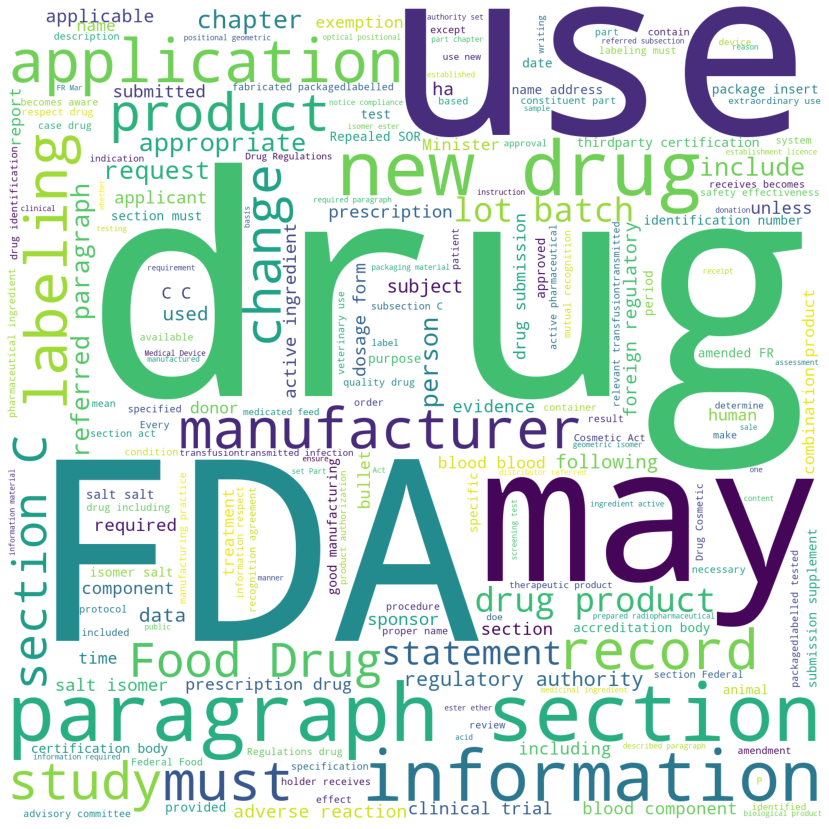

In [10]:
# WordCloud representation of the commonly occuring words in the training data
cloud = WordCloud(background_color="white",width=1500, height=1500).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(15, 15))
plt.imshow(cloud)
plt.axis('off')

In [11]:
# generate average of common words
stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['fda_desc']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['hc_desc']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
   
        return 0

    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
train_word_match.head(5)

0    0.252427
1    0.186441
2    0.146341
3    0.250000
4    0.191781
dtype: float64

In [12]:
# Find most common and least common words and weights
# If a word appears only once, ignore it
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('drug', 9.013881377321075e-05), ('section', 9.580379383023568e-05), ('product', 9.619084263178146e-05), ('shall', 9.62556550197324e-05), ('the', 9.637625289128758e-05), ('information', 9.641342074816814e-05), ('must', 9.675858732462506e-05), ('use', 9.699321047526673e-05), ('paragraph', 9.737098344693281e-05), ('may', 9.778994719342852e-05)]

Least common words and weights: 


[('infestation', 9.998000399920016e-05),
 ('waste', 9.998000399920016e-05),
 ('temporary', 9.998000399920016e-05),
 ('fulltime', 9.998000399920016e-05),
 ('course', 9.998000399920016e-05),
 ('clear', 9.998000399920016e-05),
 ('construction', 9.998000399920016e-05),
 ('toilet', 9.998000399920016e-05),
 ('services', 9.998000399920016e-05),
 ('transportation', 9.998000399920016e-05)]

In [13]:
# generate average of shared words using TF-IDF
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['fda_desc']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['hc_desc']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
tfidf_train_word_match.head()


0    0.283910
1    0.203814
2    0.144628
3    0.250429
4    0.200086
dtype: float64

In [14]:
print('Original AUC:', roc_auc_score(df_train['is_match'], train_word_match))
print('TFIDF AUC:', roc_auc_score(df_train['is_match'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.6484730344379467
TFIDF AUC: 0.6484730344379468


- AUC is a good metric since it is unaffected by scaling, so it is good for testing the predictive power of individual features.
- Overall AUC is the same even after using TF-IDF so the model so far is good.

### Rebalancing Data

It necessary to rebalance the data that XGBoost receives, since we have only 19% of positive classes in the test data. By re-balancing the data so our training set has 19% positives, we can ensure that XGBoost outputs probabilities that will better match the data on the leaderboard, and should get a better score (since LogLoss looks at the probabilities themselves and not just the order of the predictions like AUC)

In [15]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()

X_train['word_match'] = train_word_match
X_train['tfidf_word_match'] = tfidf_train_word_match

X_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
X_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_match'].values

In [16]:
print(X_train.shape)
X_train.head(3)

(100, 2)


,word_match,tfidf_word_match
0,0.252427,0.283910
1,0.186441,0.203814
2,0.146341,0.144628


In [17]:
print(X_test.shape)
X_test.head(3)

(3225, 2)


,word_match,tfidf_word_match
0,0.103448,0.113405
1,0.131737,0.141005
2,0.173913,0.189092


In [18]:
print(len(y_train))
y_train[0:5]

100


array([1, 1, 1, 1, 0])

In [19]:
pos_train = X_train[y_train == 1]
neg_train = X_train[y_train == 0]

# oversample the positive class
n = 0.19 # because 19% of the test data is positive
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / n) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

X_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19


In [20]:
print('X_Train size:',X_train.shape)
print('X_Test size:',X_test.shape)

X_Train size: (100, 2)
X_Test size: (3225, 2)


In [21]:
print('y_train length:',len(y_train))
print(Counter(y_train).keys()) # equals to list(set(words))
print(Counter(y_train).values()) # counts the elements' frequency
y_train[0:5]

y_train length: 100
dict_keys([1.0, 0.0])
dict_values([19, 81])


[1.0, 1.0, 1.0, 1.0, 1.0]

### XGBoost

Split training data into train and validation data

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
import xgboost as xgb

# parameters for xgboost
params = {'objective':'binary:logistic', #.predict_proba()
         'eval_metric':'logloss',
         'eta':0.02,
         'max_depth':4}

d_train = xgb.DMatrix(X_train, label=y_train) #train data matrix
d_valid = xgb.DMatrix(X_valid, label=y_valid) #validation data matrix

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

# fit the model
clf = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50,verbose_eval = 5)

[0]	train-logloss:0.68298	valid-logloss:0.68846
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[5]	train-logloss:0.63719	valid-logloss:0.66844
[10]	train-logloss:0.59860	valid-logloss:0.65324
[15]	train-logloss:0.56583	valid-logloss:0.64193
[20]	train-logloss:0.53786	valid-logloss:0.63378
[25]	train-logloss:0.51343	valid-logloss:0.62883
[30]	train-logloss:0.49138	valid-logloss:0.62751
[35]	train-logloss:0.47124	valid-logloss:0.62789
[40]	train-logloss:0.45344	valid-logloss:0.62944
[45]	train-logloss:0.43751	valid-logloss:0.63223
[50]	train-logloss:0.42297	valid-logloss:0.63619
[55]	train-logloss:0.40985	valid-logloss:0.64061
[60]	train-logloss:0.39776	valid-logloss:0.64703
[65]	train-logloss:0.38698	valid-logloss:0.65262
[70]	train-logloss:0.37696	valid-logloss:0.65994
[75]	train-logloss:0.36782	valid-logloss:0.66852
Stopping. Best iteration:
[29]	train-logloss:0.49566	valid-logloss:

source: https://medium.com/@fzammito/whats-considered-a-good-log-loss-in-machine-learning-a529d400632d

In [24]:
# perform prediction
d_test = xgb.DMatrix(X_test) # test data matrix
p_test = clf.predict(d_test) # prediction on test set

subset = pd.DataFrame()
subset['test_id'] = df_test['test_id']
subset['pred_match'] = p_test

print(subset.shape)
subset.head(3)

(3225, 2)


,test_id,pred_match
0,0,0.147574
1,1,0.147574
2,2,0.267914


In [25]:
# performance metrics
# best_preds = np.asarray([np.argmax(line) for line in p_test])
# print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
# print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
# print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

Add the match results of the test data:

In [26]:
df_test['is_match'] = subset['pred_match']
print(df_test.shape)
df_test.head(3)

(3225, 8)


,FDA_Code,FDA_Description,HC_Code,HC_Description,test_id,fda_desc,hc_desc,is_match
0,"""1.3""","(a) Labeling includes all written, printed,...",C.01.031,"(1) Subject to section C.01.031.2, (a) no pers...",0,labeling includes written printed graphic matt...,subject section c person shall sell drug descr...,0.147574
1,"""1.20""",In the regulations specified in 1.1(c) of this...,C.03.208,Every kit shall be labelled to show (a) its pr...,1,regulation specified chapter term package mean...,every kit shall labelled show proper name bran...,0.147574
2,"""1.21""","(a) Labeling of a food, drug, device, cosmetic...",C.01.029,(1) Subject to subsections C.01.031.2(1) and (...,2,labeling food drug device cosmetic tobacco pro...,subject subsection c inner outer label drug co...,0.267914


In [27]:
predictions = df_test.copy()
predictions.reset_index(drop=True, inplace=True)
predictions['prediction']=''
for i in range(0,len(predictions)):
    if predictions['is_match'][i] >= 0.6:
        predictions['prediction'][i] ='Y'
    else:
        predictions['prediction'][i] = 'N'
predictions.to_csv('predictions.csv',index=False)       
print(predictions.shape)
predictions.head()

(3225, 9)


,FDA_Code,FDA_Description,HC_Code,HC_Description,test_id,fda_desc,hc_desc,is_match,prediction
0,"""1.3""","(a) Labeling includes all written, printed,...",C.01.031,"(1) Subject to section C.01.031.2, (a) no pers...",0,labeling includes written printed graphic matt...,subject section c person shall sell drug descr...,0.147574,N
1,"""1.20""",In the regulations specified in 1.1(c) of this...,C.03.208,Every kit shall be labelled to show (a) its pr...,1,regulation specified chapter term package mean...,every kit shall labelled show proper name bran...,0.147574,N
2,"""1.21""","(a) Labeling of a food, drug, device, cosmetic...",C.01.029,(1) Subject to subsections C.01.031.2(1) and (...,2,labeling food drug device cosmetic tobacco pro...,subject subsection c inner outer label drug co...,0.267914,N
3,"""1.75""",In addition to the data required to be submitt...,C.08.014,(1) For the purpose of obtaining an experiment...,3,addition data required submitted ace filer mus...,purpose obtaining experimental study certifica...,0.267914,N
4,"""1.77""",In addition to the data required to be submitt...,C.02.005,The equipment with which a lot or batch of a d...,4,addition data required submitted ace filer mus...,equipment lot batch drug fabricated packagedla...,0.186029,N


Consider a subset of the test data which has the same rows as the training data:

In [28]:
FDACode_lst = df_train['FDA_Code'].to_list()
HCCode_lst = df_train['HC_Code'].to_list()

In [29]:
test_subset = predictions[predictions.FDA_Code.isin(FDACode_lst) & predictions.HC_Code.isin(HCCode_lst)]
test_subset.reset_index(drop=True, inplace=True)
# test_subset['prediction']=''
# for i in range(0,len(test_subset)):
#     if test_subset['is_match'][i] >= 0.6:
#         test_subset['prediction'][i] ='Y'
#     else:
#         test_subset['prediction'][i] = 'N'
print(test_subset.shape)
test_subset.head()

(87, 9)


,FDA_Code,FDA_Description,HC_Code,HC_Description,test_id,fda_desc,hc_desc,is_match,prediction
0,"""1.20""",In the regulations specified in 1.1(c) of this...,C.03.208,Every kit shall be labelled to show (a) its pr...,1,regulation specified chapter term package mean...,every kit shall labelled show proper name bran...,0.147574,N
1,"""1.280""",(a) You must submit the prior notice electroni...,C.01.611,"(1) The Minister may, in writing, from time to...",13,must submit prior notice electronically fda mu...,minister may writing time time require manufac...,0.147574,N
2,"""1.631""",(a) Review of recognition or renewal applicat...,C.01.050,(1) This section applies to a holder of one or...,21,review recognition renewal application fda exa...,section applies holder one following therapeut...,0.147574,N
3,"""1.633""",(a) FDA will evaluate the performance of each ...,C.01A.004,"(1) Subject to subsection (2), no person shall...",23,fda evaluate performance recognized accreditat...,subject subsection person shall except accorda...,0.186029,N
4,"""1.634""",(a) Grounds for revocation of recognition. ...,C.08.006,"(1) For the purposes of subsection (2), eviden...",24,ground revocation recognition fda revoke recog...,purpose subsection evidence new information ob...,0.374880,N


In [30]:
test_subset.to_excel('test_subset.xlsx',index=False)